# SPARSE SAMPLING OF SIGNAL INNOVATIONS

Sampling signals with Finite Rate of Innovation in the presence of measurement noise

In [1]:
import os
import numpy as np

from tqdm import tqdm

from matplotlib import style
from matplotlib import rcParams
from matplotlib import pyplot as plt

import fri_algos
import fri_utils
import fri_operators

In [2]:
# %% PLOT SETTINGS

plt.style.use(['science','ieee'])

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["cm"],
    "mathtext.fontset": "cm",
    "font.size": 24})

os.makedirs('./../figures/blu_2008/', exist_ok=True)
path = './../figures/blu_2008/'

In [ ]:
# %% GENERATE SIGNAL

np.random.seed(723)

K = 5                                                                       # Number of Diracs
TAU = 1                                                                     # Period of the signal

ak = np.sign(np.random.rand(K))*(1.0 + (np.random.randn(K) - 0.5)/1.0)      # Set amplitudes
tk = np.sort(np.random.rand(K)*TAU)   

In [ ]:
# %% KERNEL-BASED SAMPLING

# Define sampling parameters
M = K + 10                      # Number of Fourier measurements
P = M
B = (2. * M + 1)/TAU            # Bandwidth of the Dirichlet kernel
N = 2 * M + 1                   # Number of temporal samples

# Filtered signal
t_continuous = np.linspace(0,TAU,1000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
filtered_signal = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

# Temporal samples
t_unif = np.arange(0, N, dtype=float)*TAU/N
tl_grid, tk_grid = np.meshgrid(tk, t_unif)
samples_unif = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

In [ ]:
# %% PLOT SAMPLES

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_signal(t_continuous, filtered_signal, ax=ax, plot_colour='blue',
    legend_label=r'$y(t)$', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='red', legend_label=r'$x(t)$',
    show=False)
fri_utils.plot_diracs(t_unif, samples_unif, ax=ax, plot_colour='green',
    marker_style='*', legend_label=r'$y(nT_s)$', xaxis_label=r'$t$',
    title_text=r'KERNEL-BASED SAMPLING', xlimits=[0,TAU], ylimits=[-1,2],
    show=True, save=path+'sincUnifDiracSampling')

In [ ]:
# %% ADD NOISE

noisy_samples_unif = fri_utils.add_noise(samples_unif, snr=30)

In [ ]:
# %% SIGNAL RECOVERY

# Least-squares - Fourier series coefficients
forward_matrix = fri_operators.forward_matrix(t_unif, M, TAU)
fourier_coeffs = np.linalg.solve(forward_matrix, noisy_samples_unif)

# Cadzow denoising
fourier_coeffs = fri_algos.cadzow_ls(fourier_coeffs, M, P, rank=K, num_iter=50)

# Estimate delays using Prony's method
annihilating_filter = fri_algos.prony_tls(fourier_coeffs, K)
tk_estimate = fri_algos.get_shifts(annihilating_filter, TAU)

# Estimate amplitudes using linear least-squares
ak_estimate = fri_algos.get_weights(fourier_coeffs, tk_estimate, TAU)

In [ ]:
# %% COMPUTE ERRORS IN ESTIMATION

delay_estimation = np.linalg.norm(tk-tk_estimate)
amplitude_estimation = np.linalg.norm(ak-ak_estimate)

print(r'Total error in delay estimation: {0:.2e}'.format(delay_estimation))
print(r'Total error in amplitude estimation: {0:.2e}'.format(amplitude_estimation))

In [ ]:
# %% PLOT RECONSTRUCTION

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='green',
    legend_label=r'ORIGINAL SIGNAL', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk_estimate, ak_estimate, ax=ax, plot_colour='red',
    line_style='--', legend_label=r'RECONSTRUCTED SIGNAL',
    xlimits=[0,TAU], ylimits=[-1,2], xaxis_label=r'$t$', show=True,
    save=path+'sincPronyDiracReconstruction')

In [3]:
# %% MONTE-CARLO ANALYSIS

# Define signal
K = 5                                                                       # Number of Diracs
TAU = 1                                                                     # Period of the signal

ak = np.sign(np.random.rand(K))*(1.0 + (np.random.randn(K) - 0.5)/1.0)      # Set amplitudes
tk = np.sort(np.random.rand(K)*TAU)

# Define sampling parameters
M = K + 0                      # Number of Fourier measurements
P = M
B = (2. * M + 1)/TAU            # Bandwidth of the Dirichlet kernel
N = 2 * M + 1                   # Number of temporal samples

# Filtered signal
t_continuous = np.linspace(0,TAU,1000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
filtered_signal = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

# Temporal samples
t_unif = np.arange(0, N, dtype=float)*TAU/N
tl_grid, tk_grid = np.meshgrid(tk, t_unif)
samples_unif = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

# Initialise Monte-Carlo simulation
snrs = np.arange(-30,31,10)
num_iter = 100
tk_error = np.zeros((len(snrs), num_iter))
ak_error = np.zeros((len(snrs), num_iter))

for snr_itr, snr in tqdm(enumerate(snrs)):
    for avg_itr in range(num_iter):
        
        # Add noise
        awgn = np.random.randn(len(samples_unif))
        awgn = awgn / np.linalg.norm(awgn) * np.linalg.norm(samples_unif) * 10 ** (-1.0*snr / 20.)
        noisy_samples_unif = samples_unif + awgn

        # Least-squares - Fourier series coefficients
        forward_matrix = fri_operators.forward_matrix(t_unif, M, TAU)
        fourier_coeffs = np.linalg.solve(forward_matrix, noisy_samples_unif)

        # Cadzow denoising
        fourier_coeffs = fri_algos.cadzow_ls(fourier_coeffs, M, P, rank=K, num_iter=50)

        # Estimate delays using Prony's method
        annihilating_filter = fri_algos.prony_tls(fourier_coeffs, K)
        tk_estimate = fri_algos.get_shifts(annihilating_filter, TAU)

        # Estimate amplitudes using linear least-squares
        ak_estimate = fri_algos.get_weights(fourier_coeffs, tk_estimate, TAU)

        # Compute errors
        tk_error[snr_itr, avg_itr] = (np.linalg.norm(tk-tk_estimate) / np.linalg.norm(tk))
        ak_error[snr_itr, avg_itr] = (np.linalg.norm(ak-ak_estimate) / np.linalg.norm(ak))

7it [00:06,  1.10it/s]


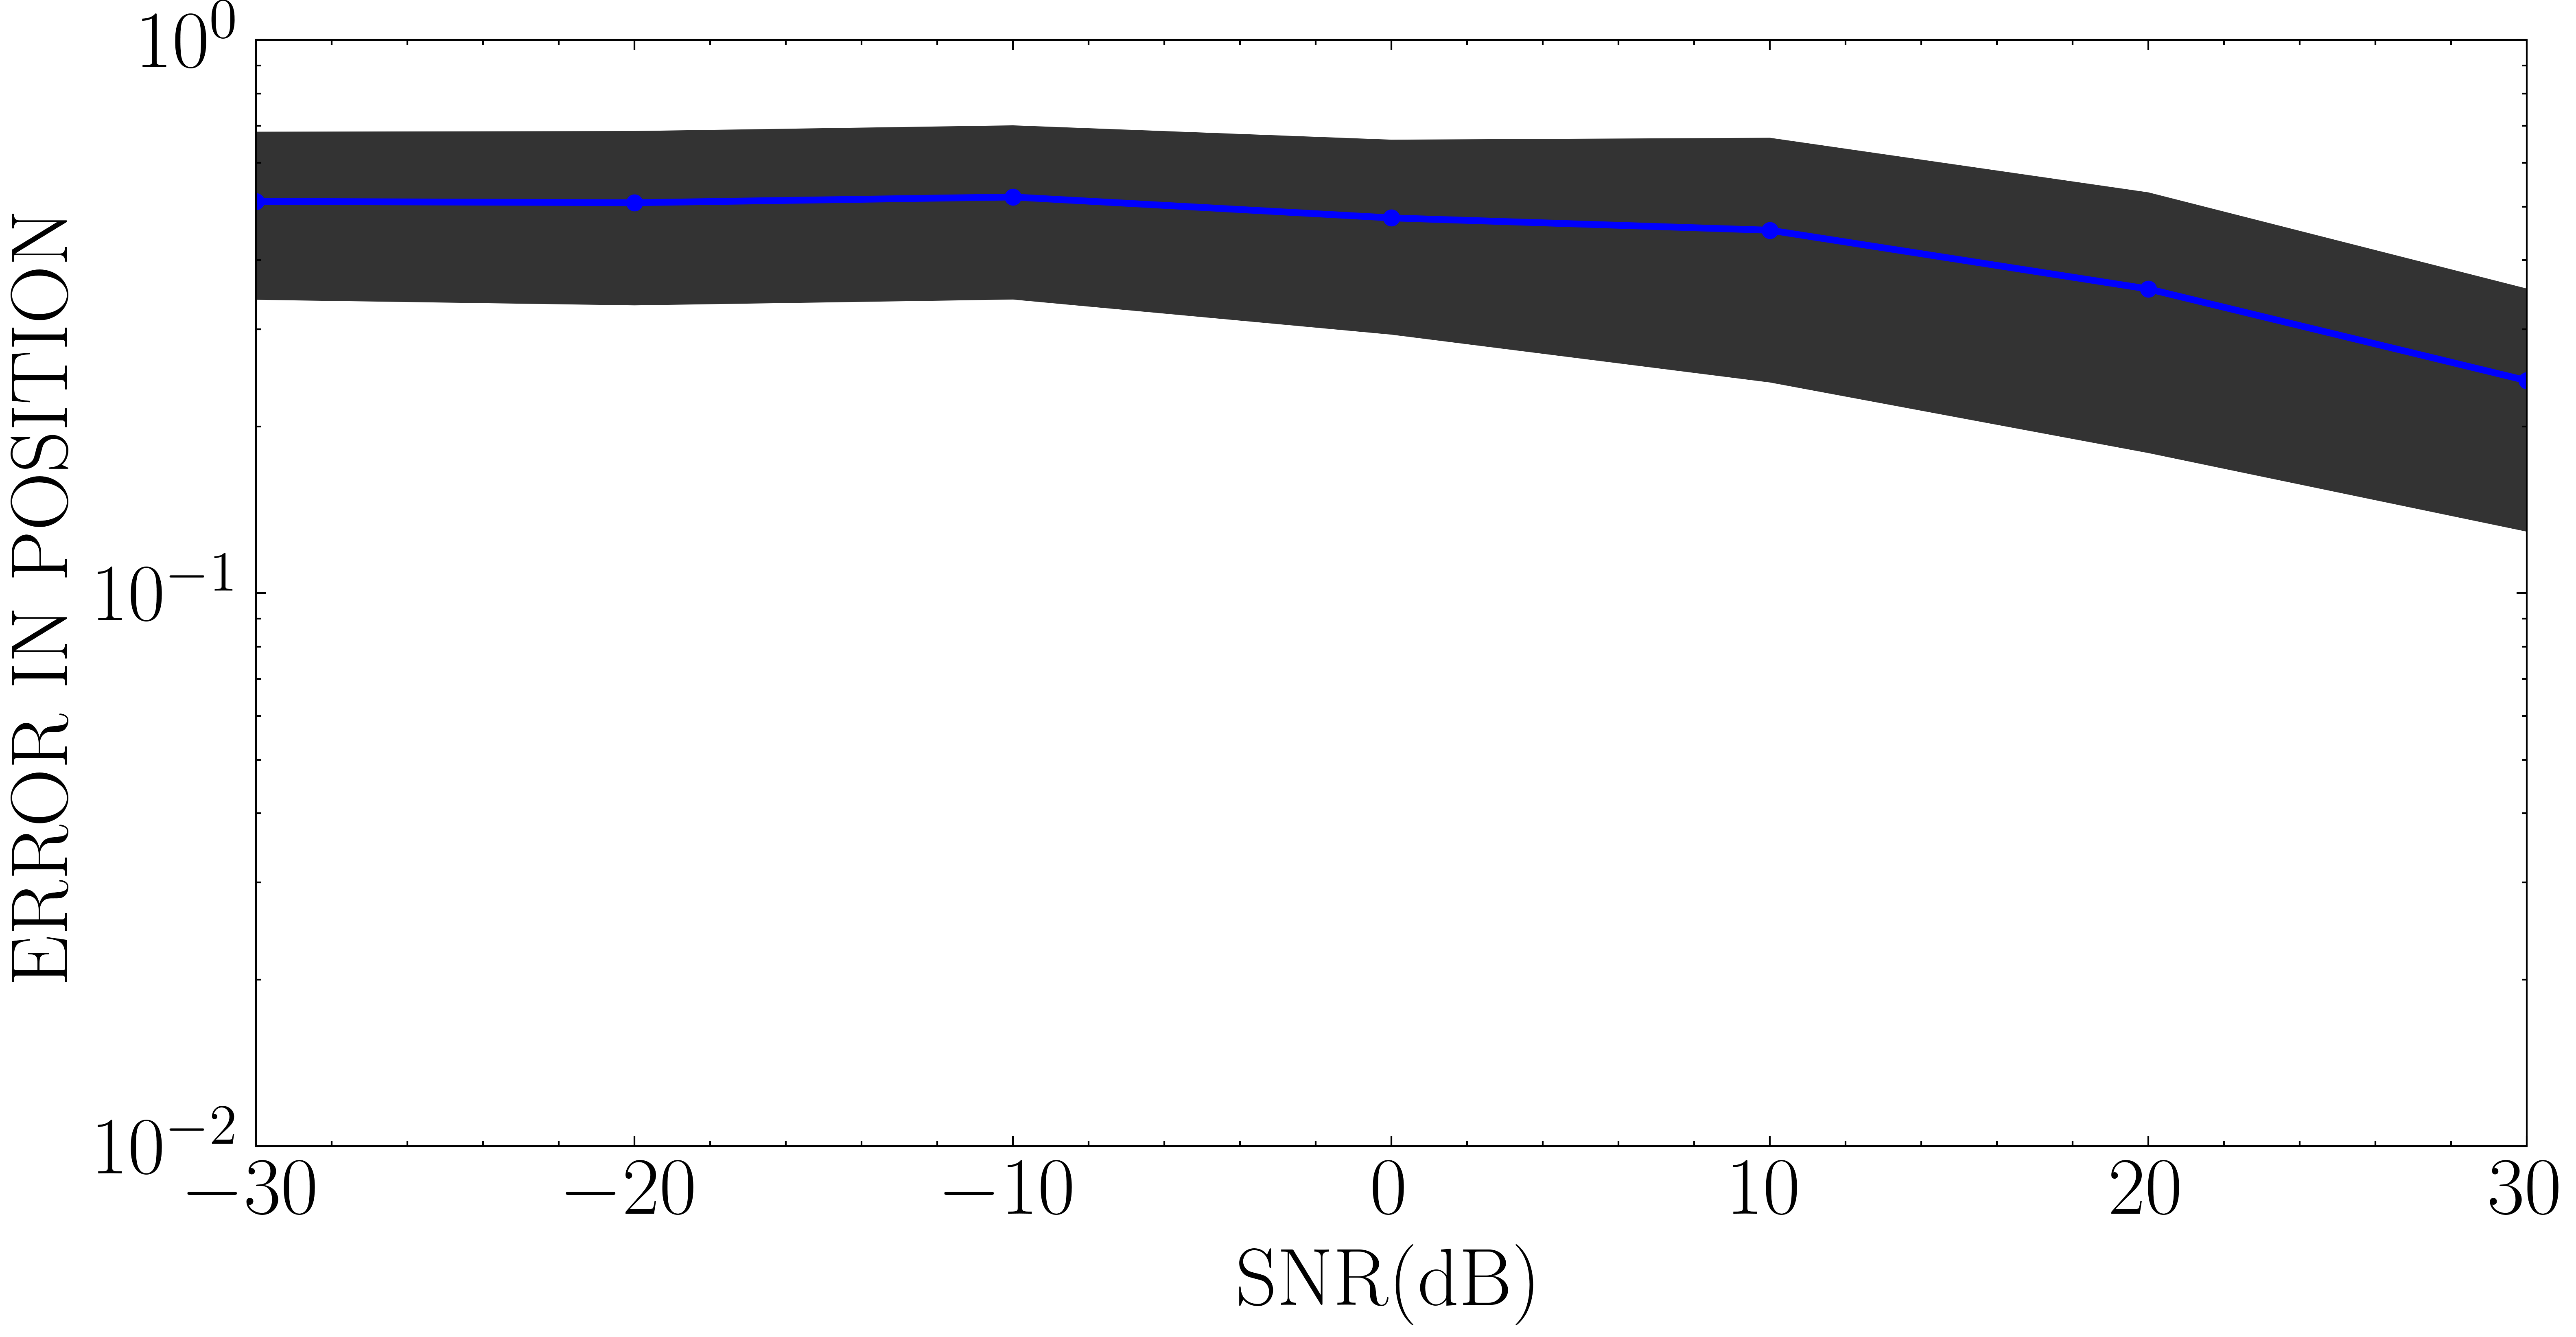

In [4]:
plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_mcerrors(snrs, tk_error, ax=ax, ylimits=[1e-2, 1e0],
    xaxis_label=r'SNR(dB)', yaxis_label=r'ERROR IN POSITION', show=True)